In [175]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import Rbf

def topoplot(datavector, chan_locs, **kwargs):
    # Set default values
    noplot = kwargs.get('noplot', 'off')
    plotgrid = kwargs.get('plotgrid', 'off')
    plotchans = kwargs.get('plotchans', [])
    handle = None
    Zi = None
    chanval = np.nan
    rmax = 0.5  # actual head radius
    INTERPLIMITS = 'head'
    INTSQUARE = 'on'
    default_intrad = 1
    ELECTRODES = kwargs.get('ELECTRODES', 'on')
    MAXDEFAULTSHOWLOCS = 64
    intrad = kwargs.get('intrad', np.nan)
    plotrad = kwargs.get('plotrad', np.nan)
    headrad = kwargs.get('headrad', 0.5)
    squeezefac = 1.0
    ContourVals = datavector
    method = kwargs.get('method', 'rbf')
    
    # Handle additional arguments
    if 'noplot' in kwargs:
        noplot = kwargs['noplot']
        if not isinstance(noplot, str):
            if len(noplot) != 2:
                raise ValueError("'noplot' location should be [radius, angle]")
            else:
                chanrad = noplot[0]
                chantheta = noplot[1]
                noplot = 'on'

    # Set colormap
    cmap = plt.get_cmap('jet')
    cmaplen = cmap.N
    GRID_SCALE = 32
    # GRID_SCALE = 67 # 67 is the default value in EEGLAB

    if len(datavector) > MAXDEFAULTSHOWLOCS:
        ELECTRODES = 'off'
    else:
        ELECTRODES = 'on'

    datavector = np.array(datavector).flatten()
    ContourVals = np.array(ContourVals).flatten()

    # Read the channel location information
    tmpeloc = chan_locs
    labels = [loc['labels'] for loc in tmpeloc]
    indices = [i for i, loc in enumerate(tmpeloc) if 'theta' in loc]
    Th = np.array([tmpeloc[i]['theta'] if i in indices and not isinstance(tmpeloc[i]['theta'], np.ndarray) else np.nan for i in range(len(tmpeloc))])
    Rd = np.array([tmpeloc[i]['radius'] if i in indices and not isinstance(tmpeloc[i]['radius'], np.ndarray) else np.nan for i in range(len(tmpeloc))])
    Th = np.deg2rad(Th)
    allchansind = list(range(len(Th)))
    plotchans = indices

    if len(tmpeloc) == len(datavector) + 1:
        if plotchans and plotchans[-1] == len(tmpeloc):
            plotchans.pop()

    if len(datavector) > 1:
        inds = np.union1d(np.where(np.isnan(datavector))[0], np.where(np.isinf(datavector))[0])
        plotchans = list(set(plotchans) - set(inds))

    x, y = np.cos(Th) * Rd, np.sin(Th) * Rd
    plotchans = np.abs(plotchans)
    allchansind = np.array(allchansind)[plotchans]
    Th, Rd, x, y = Th[plotchans], Rd[plotchans], x[plotchans], y[plotchans]
    labels = np.array(labels)[plotchans]

    if np.isnan(plotrad):
        plotrad = min(1.0, max(Rd) * 1.02)
        plotrad = max(plotrad, 0.5)

    if np.isnan(intrad):
        default_intrad = 1
        intrad = min(1.0, max(Rd) * 1.02)
    else:
        default_intrad = 0
        if plotrad > intrad:
            plotrad = intrad

    pltchans = np.where(Rd <= plotrad)[0]
    intchans = np.where((x <= intrad) & (y <= intrad) if INTSQUARE == 'on' else (Rd <= intrad))[0]

    labels = labels[pltchans]

    if datavector is not None and len(datavector) > 1:
        intdatavector = datavector[intchans]
        datavector = datavector[pltchans]
        ContourVals = ContourVals[pltchans]

    squeezefac = rmax / plotrad
    Rd, intRd = Rd * squeezefac, Rd[intchans] * squeezefac
    x, y, intx, inty = x[pltchans] * squeezefac, y[pltchans] * squeezefac, x[intchans] * squeezefac, y[intchans] * squeezefac

    if default_intrad:
        xmin, xmax = min(-rmax, min(intx)), max(rmax, max(intx))
        ymin, ymax = min(-rmax, min(inty)), max(rmax, max(inty))
    else:
        xmin, xmax, ymin, ymax = -intrad * squeezefac, intrad * squeezefac, -intrad * squeezefac, intrad * squeezefac

    xi, yi = np.linspace(xmin, xmax, GRID_SCALE), np.linspace(ymin, ymax, GRID_SCALE)
    yi, xi = np.meshgrid(yi, xi)
    
    if method == 'griddata':
        Zi = griddata((inty, intx), intdatavector, (yi, xi), method='cubic')
    else:
        coords = np.array([intx.ravel(), inty.ravel()])
        values = intdatavector.ravel()
            
        # find nan in values and remove values
        nanidx = np.where(np.isnan(values))[0]
        coords = np.delete(coords, nanidx, axis=1)
        values = np.delete(values, nanidx)

        # Create the RBF interpolator
        rbf = Rbf(coords[0], coords[1], values, function='linear')
    
        Zi = rbf(xi, yi)
        
    mask = (np.sqrt(xi**2 + yi**2) <= rmax)
    Zi[~mask] = np.nan

    if noplot == 'off':
        plt.imshow(Zi, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap=cmap)
        plt.colorbar()
        plt.scatter(x, y, c='k')
        plt.plot(np.cos(np.linspace(0, 2 * np.pi, 100)) * rmax, np.sin(np.linspace(0, 2 * np.pi, 100)) * rmax, 'k')
        for i, txt in enumerate(labels):
            plt.annotate(txt, (x[i], y[i]), fontsize=8, ha='right')
        plt.title('Topoplot')
        plt.axis('off')
        plt.show()

    return handle, Zi, plotrad, xi, yi

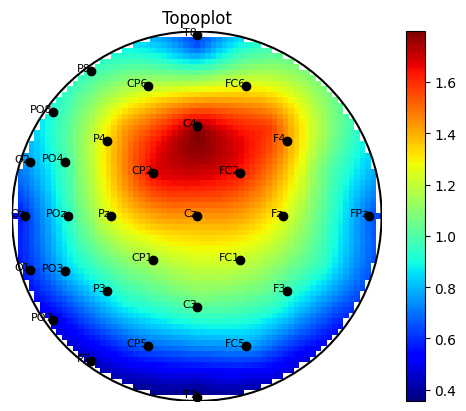

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [176]:
import scipy.io
import numpy as np

def load_matlab_file(file_path):
    # Load MATLAB file
    mat_data = scipy.io.loadmat(file_path, struct_as_record=False, squeeze_me=True)
    
    def check_keys(dict_data):
        """
        Check if entries in dictionary are mat-objects. If yes,
        _to_dict is called to change them to dictionaries.
        Recursively go through the entire structure.
        """
        for key in dict_data:
            if isinstance(dict_data[key], scipy.io.matlab.mat_struct):
                dict_data[key] = to_dict(dict_data[key])
            elif isinstance(dict_data[key], dict):
                dict_data[key] = check_keys(dict_data[key])
            elif isinstance(dict_data[key], np.ndarray) and dict_data[key].dtype == object:
                dict_data[key] = np.array([check_keys({i: item})[i] if isinstance(item, dict) else item for i, item in enumerate(dict_data[key])], dtype=object)
                if dict_data[key].size == 0:
                    dict_data[key] = None
        return dict_data

    def to_dict(matobj):
        """
        A recursive function which constructs from matobjects nested dictionaries.
        """
        dict_data = {}
        for strg in matobj._fieldnames:
            elem = getattr(matobj, strg)
            if isinstance(elem, scipy.io.matlab.mat_struct):
                dict_data[strg] = to_dict(elem)
            elif isinstance(elem, np.ndarray) and elem.dtype == object:
                dict_data[strg] = np.array([to_dict(sub_elem) if isinstance(sub_elem, scipy.io.matlab.mat_struct) else sub_elem for sub_elem in elem], dtype=object)
                if dict_data[strg].size == 0:
                    dict_data[strg] = None
            else:
                dict_data[strg] = elem
        # check if contains empty arrays
        for key in dict_data:
            if isinstance(dict_data[key], np.ndarray) and dict_data[key].size == 0:
                dict_data[key] = np.array([])
                
        return dict_data

    return check_keys(mat_data)

# Example usage:
eeglab_file_path = '/System/Volumes/Data/data/matlab/eeglab/sample_data/eeglab_data_epochs_ica.set'
EEG = load_matlab_file(eeglab_file_path)
EEG = EEG['EEG']

# Print the loaded data
res = topoplot(EEG['icawinv'].transpose()[0], EEG['chanlocs']) #, noplot='on')
res[1]
